# Sentence Embeddings

* get all sentence embeddings
* train network/ fine tune roberta model
* create a cheeky network!
* PageRank?

In [57]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import re
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx

In [ ]:
# open dataframe
complete = pd.read_csv('https://scmcqueen.github.io/StarTrekScriptData/complete_data.csv')

# get sentences
sentences = list(complete['quote'])

# preview
sentences[:5]

["   You know, Morn -- there's nothing    quite as invigorating as breakfast    in a bar. Where else can you get    raw slug livers first thing in the    morning?",
 "   What's this?",
 '   What do you mean, "what\'s this?"    It\'s puree of beetle.',
 "   I didn't order it.",
 '   Of course you "didn\'t order it" --    you don\'t need to order it. You    have it after work every morning.']

In [18]:
# load my girl roberta
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

In [ ]:
# start by completing this problem on a mini model
# baby = sentences[:100]
# embeddings = model.encode(baby) # TBD later: embeddings = model.encode(sentences)

In [ ]:
embeddings = model.encode(sentences)
# takes 4 minutes to run

In [110]:
embedding_df = pd.DataFrame(embeddings)

In [111]:
pairwise_sim = pd.DataFrame(cosine_similarity(embedding_df))
pairwise_sim # takes more than 10 minutes & crashes my kernel

: 

In [56]:
# calculate all of the stats on similarity

all_similarities = pairwise_sim.values.flatten().tolist()
print('mean:',np.mean(all_similarities))
print('median:',np.median(all_similarities))
print('quartiles:',np.percentile(all_similarities,25),np.percentile(all_similarities,50),np.percentile(all_similarities,75))
print('min & max:',np.min(all_similarities),np.max(all_similarities))

mean: 0.13989120711694705
median: 0.12085149437189102
quartiles: 0.0624198317527771 0.12085149437189102 0.18736151978373528
min & max: -0.13194957375526428 1.000000238418579


In [99]:
# lets filter by 90% quartile 
quart = np.percentile(all_similarities,90)

In [101]:
g = nx.Graph()

for x in pairwise_sim.columns:
    g.add_node(x)
    for y in pairwise_sim.columns:
        g.add_node(y)
        if y <= x:
            continue
        value = pairwise_sim[x][y]
        if value >= quart:
            g.add_edge(x,y,weight=value)

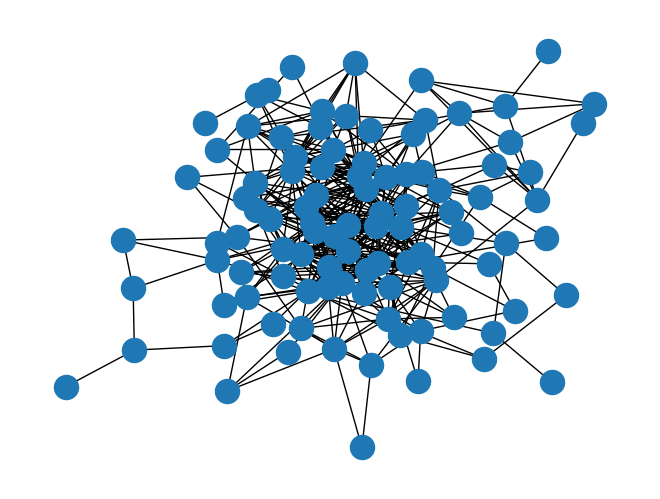

In [102]:
nx.draw_kamada_kawai(g)

In [103]:
deg = dict(nx.degree(g, weight="weight"))
avg_degree = np.mean(list(deg.values()))
print('avg degree', avg_degree)

# quote with highest degree
key_with_max_value = max(deg, key=deg.get)
key_with_max_value

avg degree 3.1338826578855516


61

In [107]:
page_rank_dict =nx.pagerank(g)
key_with_max_value = max(page_rank_dict, key=page_rank_dict.get)
key_with_max_value

61

In [105]:
baby[61]

"   No, Miles. You're not telling    anyone. If you do, I'll stop her    heart... forever."

### Now that I have embeddings, I need to see if this will work with lambda rank

In [15]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from spacy.tokens import Doc
import csv
import altair as alt

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [22]:
# read in ratings
ratings = pd.read_csv('skyeler_ranking_data.csv',index_col=0)
ratings.drop(columns=['Unnamed: 0','quote'],inplace=True)
ratings.columns=['index','query','ranking']
ratings.ranking = ratings.ranking.apply(lambda z: ratings.ranking.max()+1 if z < 0 else z)
ratings.head()

,index,query,ranking
0,113689,lwaxana,21
1,113558,lwaxana,21
2,113532,lwaxana,21
3,55180,lwaxana,21
4,55060,lwaxana,21


In [ ]:
# get index column for embeddings
embedding_df=embedding_df.reset_index()

In [ ]:
# join the data
ratings_embeddings = ratings.merge(embedding_df,on=['index'],how='left')
ratings_embeddings.head()

,index,query,ranking,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,113689,lwaxana,21,0.018398,0.012873,-0.024242,0.002963,0.049414,0.093950,-0.004741,...,0.009880,-0.042633,-0.056167,0.008068,0.013000,-0.046821,0.00999,0.005621,0.028357,0.019484
1,113558,lwaxana,21,0.016721,0.024398,-0.030568,-0.013274,0.042874,0.059577,0.034213,...,0.011101,-0.056366,-0.052283,0.000956,0.000591,-0.030117,-0.00134,0.000045,0.005712,0.018245
2,113532,lwaxana,21,0.016721,0.024398,-0.030568,-0.013274,0.042874,0.059577,0.034213,...,0.011101,-0.056366,-0.052283,0.000956,0.000591,-0.030117,-0.00134,0.000045,0.005711,0.018245
3,55180,lwaxana,21,0.018398,0.012873,-0.024242,0.002963,0.049414,0.093950,-0.004741,...,0.009880,-0.042633,-0.056167,0.008068,0.013000,-0.046821,0.00999,0.005621,0.028357,0.019484
4,55060,lwaxana,21,0.018398,0.012873,-0.024242,0.002963,0.049414,0.093950,-0.004741,...,0.009880,-0.042633,-0.056167,0.008068,0.013000,-0.046821,0.00999,0.005621,0.028357,0.019484


In [26]:
# train test split my data
train, test = train_test_split(ratings_embeddings,test_size=.15,random_state=56)
# sort my train values
train = train.sort_values('query')
test = test.sort_values('query')

In [31]:
train_y = list(train['ranking'])
train_groups = train['query'].value_counts().reset_index().sort_values('query')['count'].values
train_X = train.drop(columns=['index','query','ranking'])

In [36]:
test_y = list(test['ranking'])
test_groups = test['query'].value_counts().reset_index().sort_values('query')['count'].values
test_X = test.drop(columns=['index','query','ranking'])

In [35]:
# train_X is already prepared bc of the vectors!

In [38]:
train_data =lgb.Dataset(train_X, label=train_y, group=train_groups,params={'min_data_in_leaf':1})
valid_data = lgb.Dataset(test_X,label=test_y,group=test_groups)

In [39]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.01,
    'num_leaves': 19, # 31
    'task':'train',
    # 'feature_pre_filter':False,
    "num_leaves": 255,
    "feature_pre_filter": False,
#   "min_data_in_leaf": 1,
    'max_depth':40,
    'verbose':-1
    # 'max_depth':-1
}
res = {}

In [40]:
ranker = lgb.train(params, train_data, num_boost_round=250,valid_sets=[valid_data])

In [41]:
ranker.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('ndcg@1', 0.8278325829572262),
                          ('ndcg@2', 0.8748111947107955),
                          ('ndcg@3', 0.9000711937286457),
                          ('ndcg@4', 0.9101365714504701),
                          ('ndcg@5', 0.9225574551310549)])})